In [19]:
import os
import struct
import numpy as np
import intvalpy as ip
import matplotlib.pyplot as plt
import seaborn as sns
from functools import cmp_to_key
from pathlib import Path
from scipy.stats import linregress
from tqdm import tqdm
import math

In [20]:
def read_bin_file_with_numpy(file_path):
  with open(file_path, 'rb') as f:
    header_data = f.read(256)
    side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

    frames = []
    point_dtype = np.dtype('<8H')

    for _ in range(frame_count):
      frame_header_data = f.read(16)
      stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
      frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
      frames.append(frame_data)

    return np.array(frames)

In [21]:
def convert_to_voltage(data):
  return data / 16384.0 - 0.5

In [22]:
def scalar_to_interval(x, rad):
  return ip.Interval(x - rad, x + rad)
scalar_to_interval_vec = np.vectorize(scalar_to_interval)

In [23]:
def get_iqr(x):
  q1 = np.percentile(x, 25, axis=0)
  q3 = np.percentile(x, 75, axis=0)
  return q1, q3

In [24]:
def get_box_plot(x):
  q1 = np.percentile(x, 25, axis=0)
  q3 = np.percentile(x, 75, axis=0)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return lower_bound, upper_bound

In [25]:
def intersect_intervals(intervals):
  if len(intervals) == 0:
    return ip.Interval(np.nan, np.nan)

  result = intervals[0]

  if len(intervals) == 1:
    return result

  for interval in intervals:
    result = ip.intersection(result, interval)

  return result

In [26]:
def are_intersected(x, y):
  sup = y.a if x.a < y.a else x.a
  inf = x.b if x.b < y.b else y.b
  return sup - inf <= 1e-15

In [27]:
def are_adjusted_to_each_other(x, y):
  return x.b == y.a or y.b == x.a

In [28]:
def merge_intervals(x, y):
  return ip.Interval(min(x.a, y.a), max(x.b, y.b))

In [29]:
def mode(x):
  if len(x) == 0:
    return []

  edges = sorted({x_i.a for x_i in x}.union({x_i.b for x_i in x}))
  z = [ip.Interval(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
  mu = [sum(1 for x_i in x if z_i in x_i) for z_i in z]

  max_mu = max(mu)
  K = [index for index, element in enumerate(mu) if element == max_mu]

  m = [z[k] for k in K]
  merged_m = []

  current_interval = m[0]

  for next_interval in m[1:]:
    if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval, next_interval):
      current_interval = merge_intervals(current_interval, next_interval)
    else:
      merged_m.append(current_interval)
      current_interval = next_interval

  merged_m.append(current_interval)

  return merged_m

In [30]:
def med_k(x):
  starts = [float(interval.a) for interval in x]
  ends = [float(interval.b) for interval in x]
  return ip.Interval(np.median(starts), np.median(ends))

In [31]:
data_folder = Path('data')
files = sorted([data_folder / f for f in os.listdir(data_folder) if f.endswith('.bin')])
files

[PosixPath('data/-0.027_lvl_side_a_fast_data.bin'),
 PosixPath('data/-0.205_lvl_side_a_fast_data.bin'),
 PosixPath('data/-0.471_lvl_side_a_fast_data.bin'),
 PosixPath('data/-0.492_lvl_side_a_fast_data.bin'),
 PosixPath('data/0.061_lvl_side_a_fast_data.bin'),
 PosixPath('data/0.225_lvl_side_a_fast_data.bin'),
 PosixPath('data/0.43_lvl_side_a_fast_data.bin'),
 PosixPath('data/0_lvl_side_a_fast_data_last.bin')]

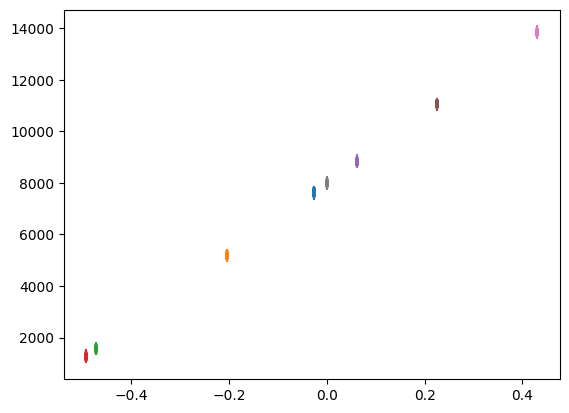

In [32]:
for file_path in files:
  x = float(file_path.name.split('_')[0])
  frames = read_bin_file_with_numpy(file_path)
  ys = []

  for frame in frames:
    px = frame.flatten()[0]
    ys.append(px)

  plt.plot([x] * len(ys), ys)

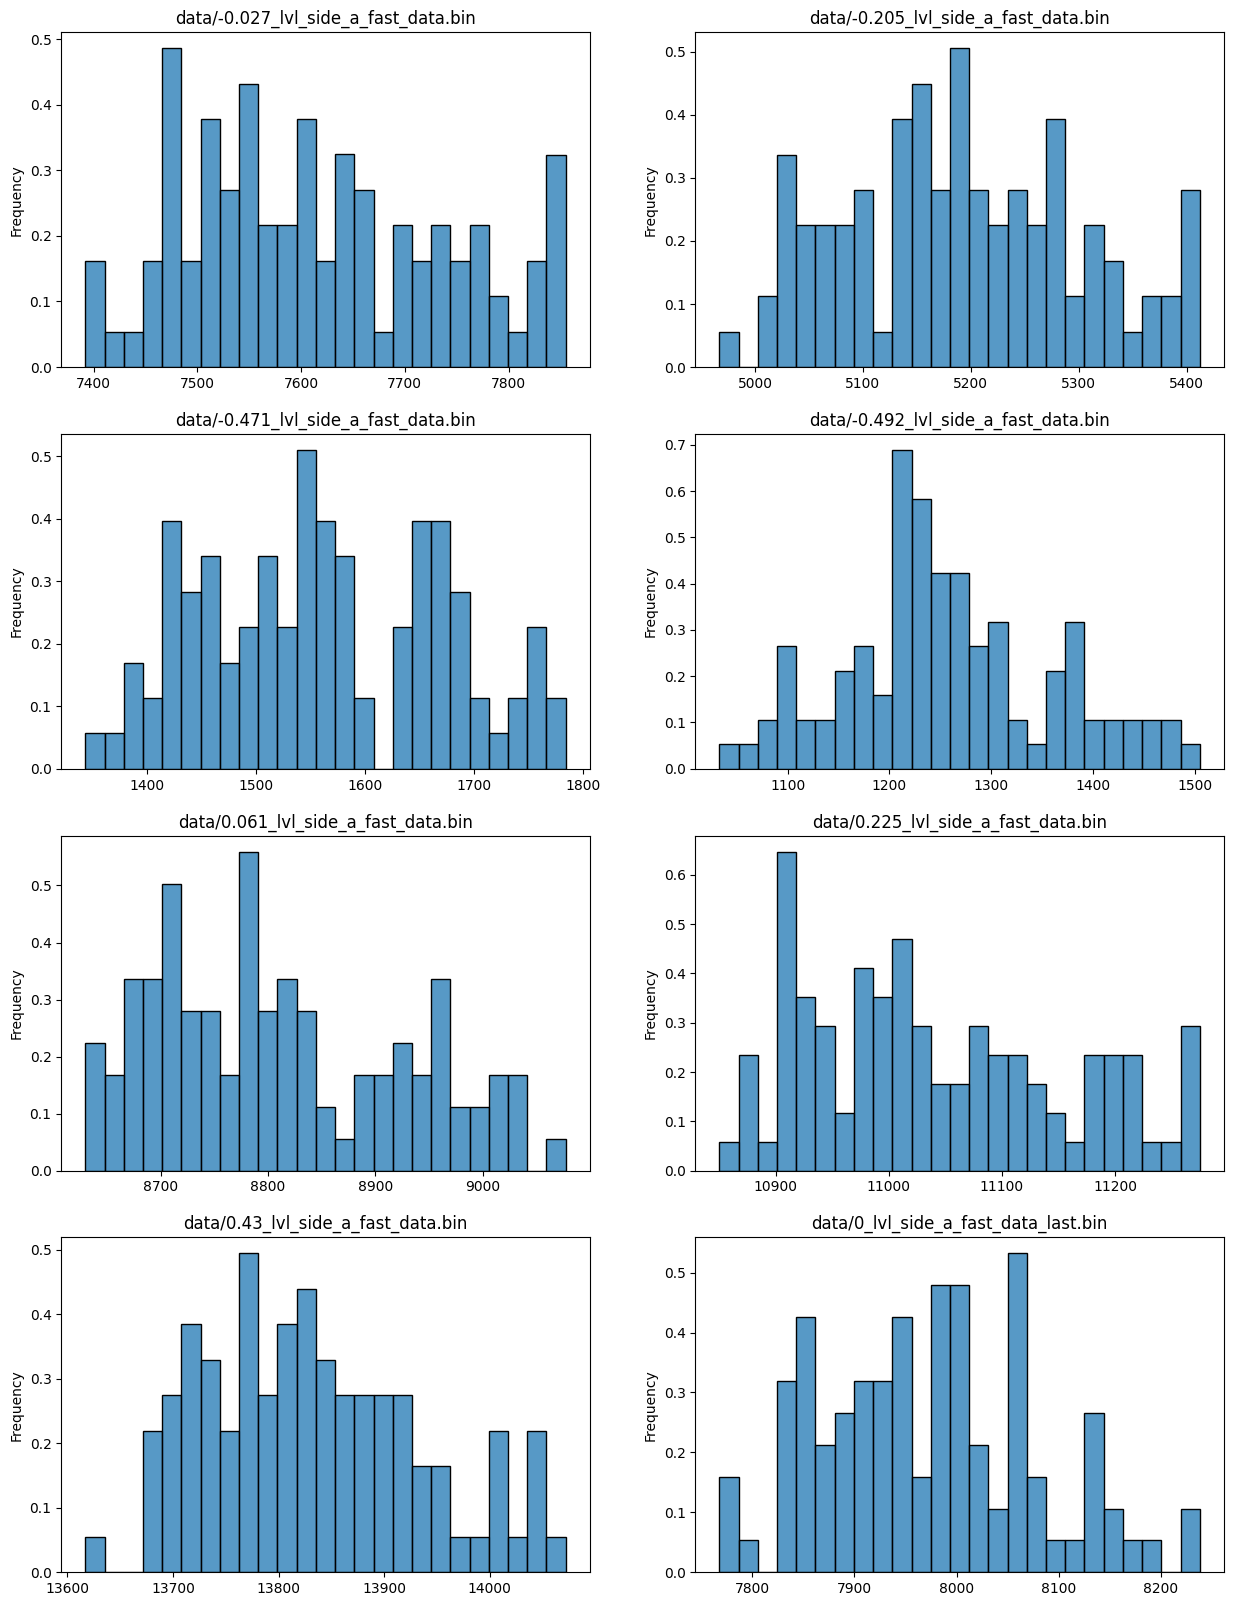

In [33]:
figure, axes = plt.subplots(int(math.ceil(len(files) / 2)), 2, figsize=(15, 20))

for index, file_path in enumerate(files):
  row_index = index // 2
  col_index = index % 2

  frames = read_bin_file_with_numpy(file_path)
  ys = []

  for frame in frames:
    px = frame.flatten()[0]
    ys.append(px)

  axis = axes[row_index][col_index]
  sns.histplot(ys, ax=axis, bins=25, stat='frequency')
  axis.set_title(file_path)


In [34]:
rad = 2 ** -9

In [35]:
estimation_functions = [
  ('IQR', get_iqr),
  ('Box plot', get_box_plot),
]

In [36]:
rad = 2 ** -9

for estimation_name, estimation_f in estimation_functions:
  beta_0s = []
  beta_1s = []

  px_num = 1024 * 8

  for px_index in tqdm(range(px_num), desc=estimation_name):
    A = []
    b = []

    for file_path in files:
      x = float(file_path.name.split('_')[0])
      frames = read_bin_file_with_numpy(file_path)
      ys = []

      for frame in frames:
        px = frame.flatten()[px_index]
        ys.append(px)

      y = estimation_f(ys)

      A.append([[x - rad, x + rad], [1 - rad, 1 + rad]])
      b.append(y)

    A = ip.Interval(A)
    b = ip.Interval(b)

    x = ip.linear.Rohn(A, b)
    beta_0s.append(x[1])
    beta_1s.append(x[0])

  beta_0_intersected = intersect_intervals(beta_0s)
  beta_1_intersected = intersect_intervals(beta_1s)
  print('Intersection: ', beta_0_intersected, beta_1_intersected)

  beta_0_med_k = med_k(beta_0s)
  beta_1_med_k = med_k(beta_1s)
  print('Med_k: ', beta_0_med_k, beta_1_med_k)

  # beta_0_mode = mode(beta_0s)
  # beta_1_mode = mode(beta_1s)
  # print('Mode: ', beta_0_mode, beta_1_mode)

IQR: 100%|██████████| 8192/8192 [01:06<00:00, 123.93it/s]


Intersection:  '[8077.28, 8077.98]' '[nan, nan]'
Med_k:  '[7986.82, 8233.07]' '[12740.6, 13405.6]'


Box plot: 100%|██████████| 8192/8192 [01:05<00:00, 125.82it/s]


Intersection:  '[7885.3, 8266.58]' '[12977, 13688.5]'
Med_k:  '[7736.37, 8474.22]' '[12072, 14071.8]'


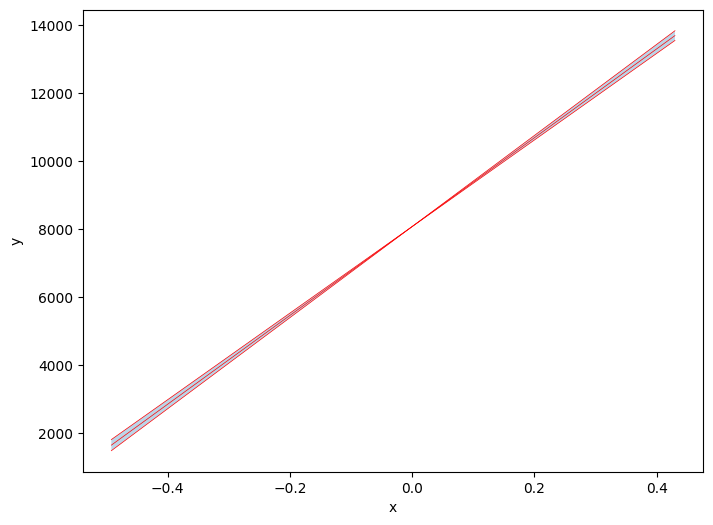

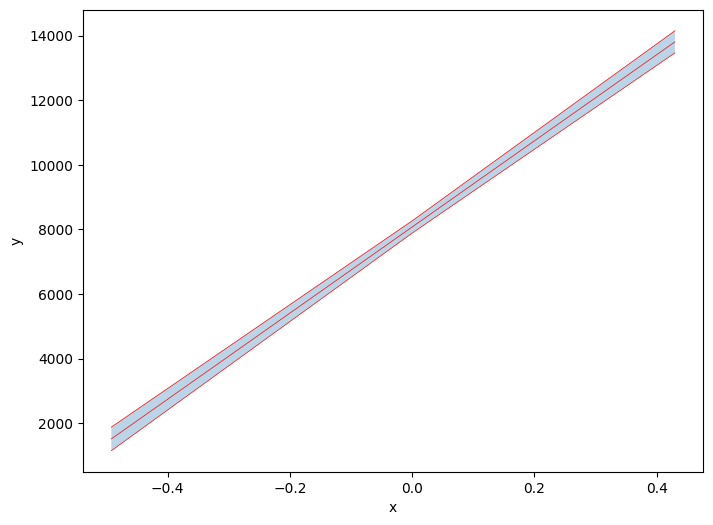

In [37]:
beta_0_int = ip.Interval(8077.28, 8077.98)
beta_1_int = ip.Interval(12740.6, 13405.6)

beta_0_ext = ip.Interval(7885.3, 8266.58)
beta_1_ext = ip.Interval(12977, 13688.5)

xs = np.array([float(file_path.name.split('_')[0]) for file_path in files])
xs_continuous = np.linspace(xs.min(), xs.max(), 100)

for (beta_0, beta_1) in ((beta_0_int, beta_1_int), (beta_0_ext, beta_1_ext)):
  ys = beta_0 + beta_1 * xs_continuous
  ys_a = np.array([float(interval.a) for interval in ys])
  ys_b = np.array([float(interval.b) for interval in ys])

  plt.figure(figsize=(8, 6))
  plt.fill_between(xs_continuous, ys_a, ys_b, alpha=0.3)
  plt.plot(xs_continuous, ys_a, color='red', linewidth=0.5)
  plt.plot(xs_continuous, ys_b, color='red', linewidth=0.5)
  plt.plot(xs_continuous, (ys_a + ys_b) / 2, color='red', linewidth=0.5)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()